In [1]:
# # Text Analysis of Conversation Data
#
# This notebook analyzes the conversation data from JSON files to extract insights about:
# 1. Message patterns
# 2. Intent classification
# 3. Sentiment analysis
# 4. Topic clustering
# 5. Temporal patterns

# Note: The following line was originally a notebook cell command.
# Run this in your terminal or environment if you don't have these packages:
# pip install nltk pandas numpy matplotlib seaborn vaderSentiment

import sys # Used for exiting script on critical errors
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# Attempt NLTK import and setup
try:
    import nltk
    from nltk.tokenize import word_tokenize, sent_tokenize
    from nltk.corpus import stopwords
    from nltk.probability import FreqDist
except ImportError:
    print("Error: NLTK library not found.")
    print("Please install it using: pip install nltk")
    sys.exit(1) # Exit if essential library is missing

# Attempt VADER import
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except ImportError:
    print("Error: vaderSentiment library not found.")
    print("Please install it using: pip install vaderSentiment")
    sys.exit(1) # Exit if essential library is missing


# Setup NLTK data (download if missing)
print("Setting up NLTK data...")
# Reduced the list to what's used in the script based on the notebook code provided
required_nltk_resources = {
    'tokenizers/punkt': 'punkt',
    'corpora/stopwords': 'stopwords',
    # 'corpora/wordnet': 'wordnet', # Not explicitly used in the provided cells
    # 'taggers/averaged_perceptron_tagger': 'averaged_perceptron_tagger' # Not used
}

for path, resource_name in required_nltk_resources.items():
    try:
        nltk.data.find(path)
        print(f"NLTK resource '{resource_name}' found.")
    except LookupError:
        print(f"Downloading NLTK resource '{resource_name}'...")
        try:
            nltk.download(resource_name)
        except Exception as e:
            print(f"Error downloading NLTK resource '{resource_name}': {e}")
            print("Please ensure you have an internet connection and try again.")
            # Depending on importance, might exit here: sys.exit(1)
print("NLTK setup complete!")

Setting up NLTK data...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MR.Laptops\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


NLTK setup complete!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MR.Laptops\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [5]:
# Set style for plots
try:
    plt.style.use('seaborn-v0_8-darkgrid') # Use a more current style name
except:
    plt.style.use('ggplot') # Fallback style
sns.set_palette('husl')

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20) # Set to a reasonable number, None can be very long
pd.set_option('display.width', 1000) # Adjust width as needed

print("Libraries imported and configured successfully!")

Libraries imported and configured successfully!


Loading data...

Data loaded successfully!
Number of messages: 312

Sample messages:
                                             content                  intent     sender  hour
0    Is my salary range meeting market expectations?         candidateAssist  candidate    21
1  To determine if your salary range is meeting m...         candidateAssist        bot    21
2            What type of roles would be a good fit?         candidateAssist  candidate    23
3  Based on the ENTP personality type, here are s...         candidateAssist        bot    23
4                  What is Mr. Beast's culture like?  candidateCompanyAssist  candidate    23

Message distribution by sender (%):
sender
candidate    50.0%
bot          50.0%
Name: proportion, dtype: object

Message distribution by intent (%):
intent
candidateJobAssist                 60.26%
candidateAssist                    21.79%
candidateCompanyAssist              14.1%
candidateJobAssistLoggedOut         3.21%
candidateCompanyAssistLog

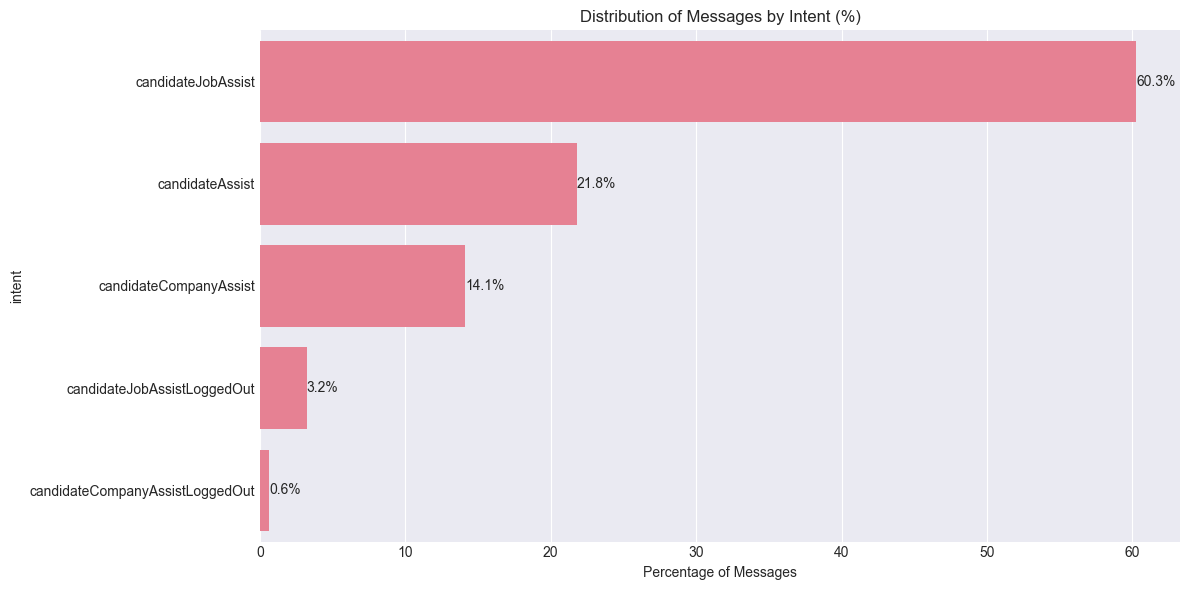

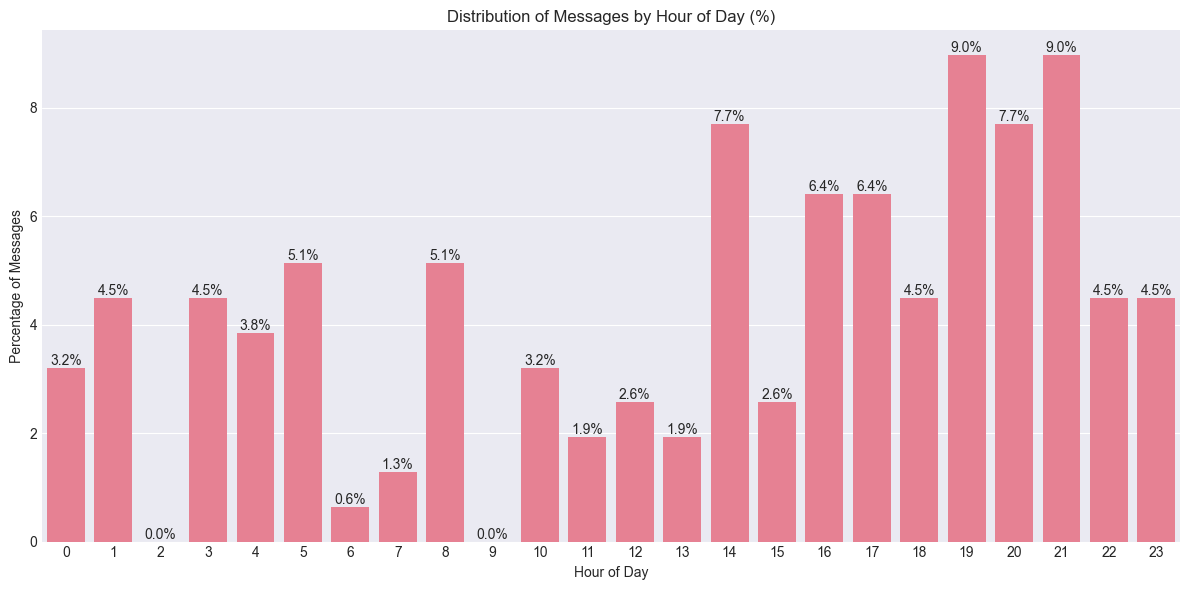


Analysis complete! Check 'intent_distribution_percent.png' and 'messages_by_hour_percent.png' for visualizations.

Top 5 most common intents:
candidateJobAssist: 60.26%
candidateAssist: 21.79%
candidateCompanyAssist: 14.10%
candidateJobAssistLoggedOut: 3.21%
candidateCompanyAssistLoggedOut: 0.64%

Hourly activity peaks:
19:00 - 9.0% of messages
21:00 - 9.0% of messages
14:00 - 7.7% of messages

Distribution by time of day:
Evening: 36.5%
Night: 25.0%
Afternoon: 21.2%
Morning: 17.3%


In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
print("Loading data...")
with open('Parallel-Prod.AssistMessage.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Convert timestamps and extract time components
df['createdAt'] = pd.to_datetime(df['createdAt'].apply(lambda x: x['$date']))
# Create time-based columns
df['hour'] = df['createdAt'].dt.hour
df['day'] = df['createdAt'].dt.day
df['month'] = df['createdAt'].dt.month

print("\nData loaded successfully!")
print(f"Number of messages: {len(df)}")

# Display sample
print("\nSample messages:")
print(df[['content', 'intent', 'sender', 'hour']].head())

# Basic analysis with percentages
print("\nMessage distribution by sender (%):")
sender_pcts = df['sender'].value_counts(normalize=True) * 100
print(sender_pcts.round(2).astype(str) + '%')

print("\nMessage distribution by intent (%):")
intent_pcts = df['intent'].value_counts(normalize=True) * 100
print(intent_pcts.round(2).astype(str) + '%')

# Plot intent distribution with percentages
plt.figure(figsize=(12, 6))
# Calculate percentages for intents
intent_counts = df['intent'].value_counts(normalize=True) * 100

# Create bar plot with percentages
sns.barplot(x=intent_counts.values, y=intent_counts.index)
plt.title('Distribution of Messages by Intent (%)')
plt.xlabel('Percentage of Messages')
# Add percentage labels on the bars
for i, v in enumerate(intent_counts):
    plt.text(v, i, f'{v:.1f}%', va='center')
plt.tight_layout()
plt.show()
plt.savefig('intent_distribution_percent.png')
plt.close()

# Time analysis with percentages
plt.figure(figsize=(12, 6))

# Create a Series with all hours (0-23) initialized to 0
all_hours = pd.Series(0, index=range(24))
# Add the actual hour counts
hour_counts = df['hour'].value_counts(normalize=True) * 100
# Update all_hours with actual values while keeping 0 for missing hours
hour_counts = all_hours.add(hour_counts, fill_value=0)
# Sort by hour
hour_counts = hour_counts.sort_index()

# Create bar plot with percentages
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title('Distribution of Messages by Hour of Day (%)')
plt.xlabel('Hour of Day')
plt.ylabel('Percentage of Messages')
# Add percentage labels on the bars
for i, v in enumerate(hour_counts):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
plt.xticks(range(24))  # Show all 24 hours
plt.tight_layout()
plt.show()
plt.savefig('messages_by_hour_percent.png')
plt.close()

print("\nAnalysis complete! Check 'intent_distribution_percent.png' and 'messages_by_hour_percent.png' for visualizations.")

# Additional percentage-based analysis
print("\nTop 5 most common intents:")
top_intents = intent_pcts.head()
for intent, pct in top_intents.items():
    print(f"{intent}: {pct:.2f}%")

print("\nHourly activity peaks:")
top_hours = hour_counts.nlargest(3)
for hour, pct in top_hours.items():
    print(f"{hour:02d}:00 - {pct:.1f}% of messages")

# Add time of day analysis
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

df['time_of_day'] = df['hour'].apply(get_time_of_day)
time_of_day_pcts = df['time_of_day'].value_counts(normalize=True) * 100

print("\nDistribution by time of day:")
for time, pct in time_of_day_pcts.items():
    print(f"{time}: {pct:.1f}%")

Script started.
File 'Parallel-Prod.AssistMessage.json' found. Size: 0.39 MB
Loading data...
File opened. Starting json.load()... This might take time for large files.
json.load() successful.
Starting pd.DataFrame conversion...
pd.DataFrame() successful. DataFrame shape: (312, 12)

Calling analyze_basic_stats function...

Analyzing basic message statistics...
Total messages: 312

Messages by sender:
sender
candidate    156
bot          156
Name: count, dtype: int64

Messages by intent:
intent
candidateJobAssist                 188
candidateAssist                     68
candidateCompanyAssist              44
candidateJobAssistLoggedOut         10
candidateCompanyAssistLoggedOut      2
Name: count, dtype: int64

Message length statistics:
count     312.000000
mean      597.201923
std       720.519151
min         2.000000
25%        26.000000
50%        69.000000
75%      1159.750000
max      2815.000000
Name: msg_length, dtype: float64

Generating plots...


C:\Users\MR.Laptops\AppData\Local\Temp\ipykernel_31620\4178531719.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


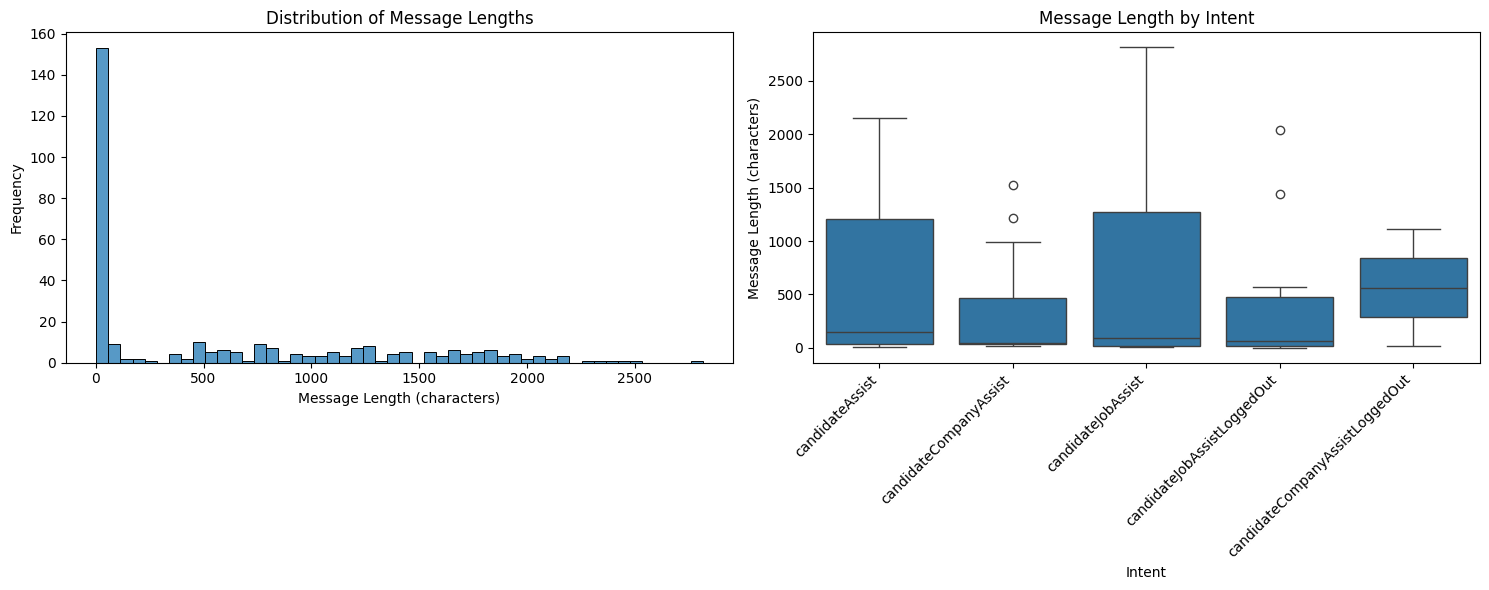


Script finished.


In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys # Import sys to get file size if needed
import os  # Import os to check file size

# Define the analysis function first
def analyze_basic_stats(df):
    """Performs and plots basic analysis on message stats."""
    if df is None or df.empty:
        print("No message data available to analyze basic stats!")
        return df # Return unmodified df

    print("\nAnalyzing basic message statistics...") # Added newline for clarity

    print("Total messages:", len(df))

    # Check for required columns before analysis
    if 'sender' in df.columns:
        print("\nMessages by sender:")
        print(df['sender'].value_counts())
    else:
        print("\nWarning: 'sender' column not found.")

    if 'intent' in df.columns:
        print("\nMessages by intent:")
        print(df['intent'].value_counts())
    else:
        print("\nWarning: 'intent' column not found.")

    if 'content' in df.columns:
        # Ensure content is string before length calculation
        df['content'] = df['content'].astype(str)
        df['msg_length'] = df['content'].str.len()

        print("\nMessage length statistics:")
        # Use .describe() safely
        if not df['msg_length'].empty:
             print(df['msg_length'].describe())
        else:
             print("No message lengths to describe.")

        # Plotting
        print("\nGenerating plots...") # Indicate plotting is starting
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Message length distribution
        sns.histplot(data=df, x='msg_length', bins=50, ax=axes[0])
        axes[0].set_title('Distribution of Message Lengths')
        axes[0].set_xlabel('Message Length (characters)')
        axes[0].set_ylabel('Frequency') # Added Y label

        # Message length by intent (only if intent exists)
        if 'intent' in df.columns:
            sns.boxplot(data=df, x='intent', y='msg_length', ax=axes[1])
            # Rotate labels only if there are labels to rotate
            if len(axes[1].get_xticklabels()) > 0:
                 axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
            axes[1].set_title('Message Length by Intent')
            axes[1].set_xlabel('Intent') # Added X label
            axes[1].set_ylabel('Message Length (characters)') # Added Y label
        else:
            axes[1].set_title('Message Length by Intent (Intent column missing)')
            axes[1].text(0.5, 0.5, 'Intent data not available',
                         horizontalalignment='center', verticalalignment='center',
                         transform=axes[1].transAxes)

        plt.tight_layout()
        plt.show() # Display the plots for this function
    else:
        print("\nWarning: 'content' column not found, skipping length analysis.")

    return df # Return df potentially with 'msg_length' column


# --- Main script execution ---
print("Script started.")

# Define filename
filename = 'Parallel-Prod.AssistMessage.json'

# Check file existence and size before trying to load
if not os.path.exists(filename):
    print(f"Error: File '{filename}' not found in the current directory.")
    sys.exit(1) # Exit if file doesn't exist

try:
    file_size_mb = os.path.getsize(filename) / (1024 * 1024)
    print(f"File '{filename}' found. Size: {file_size_mb:.2f} MB")
    if file_size_mb > 500: # Threshold for potential memory issues (adjust as needed)
        print("Warning: File size is large. Loading may consume significant memory or fail.")
except Exception as e:
    print(f"Could not get file size for '{filename}': {e}")

# Add try-except block for robust error handling during load and processing
try:
    print("Loading data...")
    with open(filename, 'r', encoding='utf-8') as f:
        print("File opened. Starting json.load()... This might take time for large files.", flush=True)
        data = json.load(f)
        print(f"json.load() successful.", flush=True)
        # Optional: Check type/size of loaded data if helpful
        # if isinstance(data, list):
        #     print(f"Loaded data is a list with {len(data)} elements.")

    print("Starting pd.DataFrame conversion...", flush=True)
    df = pd.DataFrame(data)
    print(f"pd.DataFrame() successful. DataFrame shape: {df.shape}", flush=True)

    # *** CRITICAL: Call the analysis function ***
    print("\nCalling analyze_basic_stats function...")
    analyze_basic_stats(df)

except FileNotFoundError:
    # This case is technically handled by the os.path.exists check above,
    # but kept here for completeness in the try block.
    print(f"Error: File '{filename}' not found.")
except json.JSONDecodeError as e:
    print(f"Error: File '{filename}' is not valid JSON. Details: {e}")
except MemoryError:
    print(f"Error: Ran out of memory trying to load or process '{filename}'.")
    print("The JSON file is likely too large for standard loading.")
    print("Consider using a streaming JSON parser like 'ijson' for large files.")
except Exception as e:
    # Catch any other unexpected errors
    print(f"An unexpected error occurred: {e}")
    # You might want to print the full traceback for debugging:
    # import traceback
    # traceback.print_exc()

print("\nScript finished.")


--- Starting Data Loading ---
Loading Parallel-Prod.AssistMessage.json...
Successfully loaded Parallel-Prod.AssistMessage.json
Loading Parallel-Prod.AssistThread.json...
Successfully loaded Parallel-Prod.AssistThread.json

Loaded 312 messages.

--- Preprocessing Message Data ---
Converting 'createdAt' timestamps...
'createdAt' converted. 312 messages remain.

Messages Dataset Info (Post-Preprocessing):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   _id             312 non-null    object             
 1   content         312 non-null    object             
 2   sender          312 non-null    object             
 3   intent          312 non-null    object             
 4   assistThreadId  312 non-null    object             
 5   candidateId     300 non-null    object             
 6   botMessageId    312 non-null

C:\Users\MR.Laptops\AppData\Local\Temp\ipykernel_31620\4178531719.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


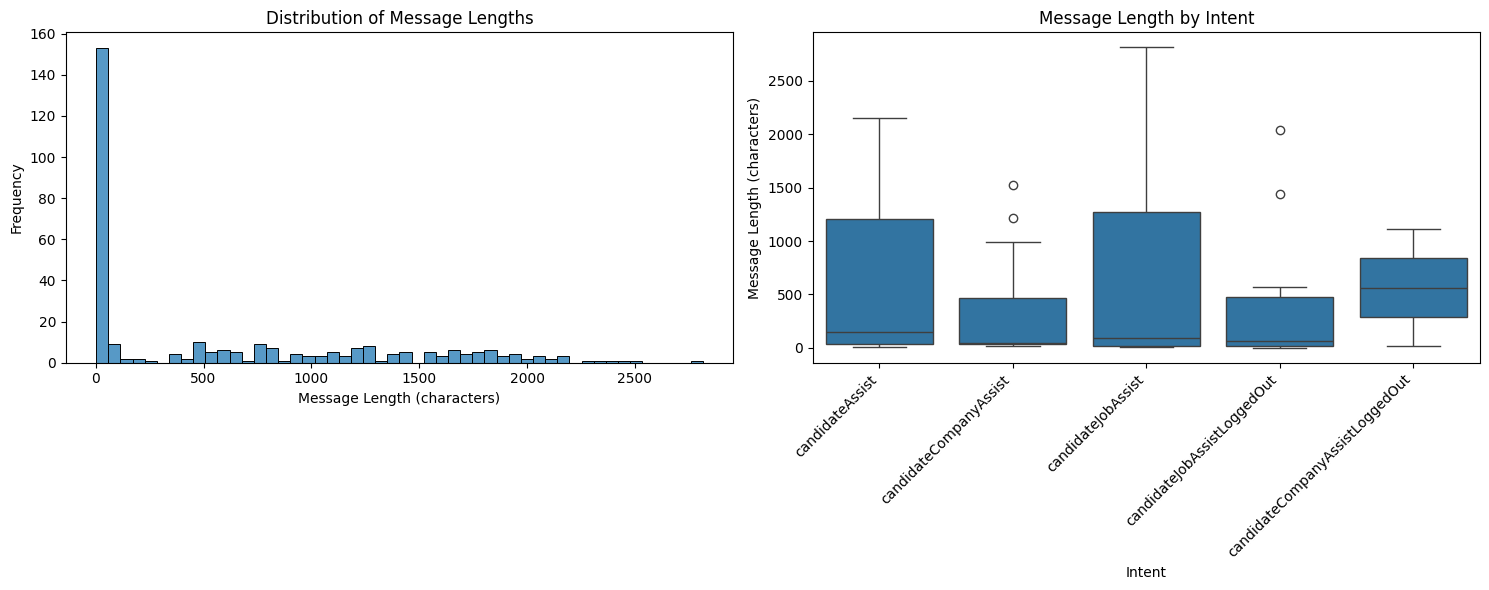


Analyzing message content...


NameError: name 'stopwords' is not defined

In [6]:

# ## 3. Content Analysis
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def load_json_file(filename):
    """Load a JSON file and return its contents."""
    try:
        print(f"Loading {filename}...")
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded {filename}")
        return data
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found!")
        return None
    except json.JSONDecodeError:
        print(f"Error: File '{filename}' is not valid JSON!")
        return None
    except Exception as e:
        print(f"An unexpected error occurred loading '{filename}': {e}")
        return None


def analyze_content(df):
    """Performs word frequency and sentiment analysis."""
    if df is None or df.empty:
        print("No message data available to analyze content!")
        return df # Return unmodified df

    if 'content' not in df.columns:
        print("Warning: 'content' column not found. Skipping content analysis.")
        return df

    print("\nAnalyzing message content...")

    # Ensure content is string
    df['content'] = df['content'].astype(str)

    # Get stopwords
    stop_words = set(stopwords.words('english'))

    # Process text function
    def process_text(text):
        try:
            tokens = word_tokenize(text.lower())
            return [word for word in tokens if word.isalnum() and word not in stop_words]
        except Exception as e:
            # Handle potential errors during tokenization, e.g., unusual characters
            # print(f"Warning: Could not tokenize text snippet: '{text[:50]}...' Error: {e}")
            return [] # Return empty list on error

    # Process all texts
    print("Processing texts for word frequency...")
    all_words = []
    # Use apply for potentially better performance on large datasets
    df['content'].apply(lambda text: all_words.extend(process_text(text)))

    if not all_words:
         print("No words found after processing texts. Skipping frequency analysis.")
    else:
        # Word frequency analysis
        print("\nAnalyzing word frequencies...")
        fdist = FreqDist(all_words)

        # Plotting Top Words
        fig_freq, ax_freq = plt.subplots(figsize=(12, 7)) # Create figure for frequency plot

        top_words_count = 20
        if len(fdist) > 0:
            top_words = pd.DataFrame(fdist.most_common(top_words_count), columns=['word', 'count'])
            sns.barplot(data=top_words, x='count', y='word', ax=ax_freq, palette='viridis') # Added palette
            ax_freq.set_title(f'{top_words_count} Most Common Words (excluding stopwords)')
            ax_freq.set_xlabel('Count') # Added X label
            ax_freq.set_ylabel('Word') # Added Y label
        else:
             ax_freq.set_title(f'{top_words_count} Most Common Words (No words found)')
             ax_freq.text(0.5, 0.5, 'No word frequency data available',
                         horizontalalignment='center', verticalalignment='center',
                         transform=ax_freq.transAxes)

        plt.tight_layout() # Apply layout adjustments for the frequency plot
        plt.show() # Show frequency plot

    # Sentiment analysis
    print("\nAnalyzing sentiment...")
    analyzer = SentimentIntensityAnalyzer()

    # Define safe sentiment scoring function
    def get_sentiment_score(text):
        try:
            # Ensure text is string for VADER
            return analyzer.polarity_scores(str(text))['compound']
        except Exception as e:
            # print(f"Warning: Could not analyze sentiment for text snippet: '{text[:50]}...' Error: {e}")
            return 0.0 # Return neutral on error

    df['sentiment'] = df['content'].apply(get_sentiment_score)

    # Plot Sentiment Distribution
    fig_sent, ax_sent = plt.subplots(figsize=(12, 6)) # Create figure for sentiment plot

    sns.histplot(data=df, x='sentiment', bins=50, kde=True, ax=ax_sent) # Added KDE
    ax_sent.set_title('Distribution of Message Sentiment (VADER Compound Score)')
    ax_sent.set_xlabel('Sentiment Score (-1 Negative to +1 Positive)') # Added X label
    ax_sent.set_ylabel('Frequency') # Added Y label

    plt.tight_layout() # Apply layout adjustments for the sentiment plot
    plt.show() # Show sentiment plot

    # Print sentiment statistics
    print("\nSentiment statistics:")
    if not df['sentiment'].empty:
        print(df['sentiment'].describe())
    else:
        print("No sentiment scores to describe.")

    return df # Return df with added 'sentiment' column


# --- Main Execution Block ---
if __name__ == "__main__":

    # Define filenames
    messages_filename = 'Parallel-Prod.AssistMessage.json'
    threads_filename = 'Parallel-Prod.AssistThread.json'

    # Load the main conversation data
    print("--- Starting Data Loading ---")
    messages = load_json_file(messages_filename)
    threads = load_json_file(threads_filename) # Load threads even if not used in provided analysis funcs

    # Initialize DataFrames as None
    messages_df = None
    threads_df = None

    # Proceed only if message data loaded successfully
    if messages is not None:
        messages_df = pd.DataFrame(messages)
        print(f"\nLoaded {len(messages_df)} messages.")

        # --- Data Preprocessing ---
        print("\n--- Preprocessing Message Data ---")
        # Convert timestamps ('createdAt.$date') with robust error handling
        if 'createdAt' in messages_df.columns:
            print("Converting 'createdAt' timestamps...")
            original_rows = len(messages_df)
            # Define a safe conversion function
            def safe_convert_date(x):
                if isinstance(x, dict) and '$date' in x:
                    return pd.to_datetime(x['$date'], errors='coerce')
                # Add handling for other potential formats if necessary
                # elif isinstance(x, str):
                #     return pd.to_datetime(x, errors='coerce')
                return pd.NaT # Return Not-a-Time for unexpected formats

            messages_df['createdAt'] = messages_df['createdAt'].apply(safe_convert_date)

            # Check for and drop rows where timestamp conversion failed
            rows_before_drop = len(messages_df)
            messages_df.dropna(subset=['createdAt'], inplace=True)
            rows_after_drop = len(messages_df)
            if rows_before_drop > rows_after_drop:
                print(f"Dropped {rows_before_drop - rows_after_drop} rows due to invalid 'createdAt' format.")

            if messages_df.empty:
                 print("Error: No valid messages remaining after timestamp conversion.")
                 messages_df = None # Set back to None if empty
            else:
                 print(f"'createdAt' converted. {len(messages_df)} messages remain.")

        else:
            print("Warning: 'createdAt' column not found in messages data. Temporal analysis may fail.")
            # Decide if this is critical: sys.exit(1)?

        # Display info if df exists
        if messages_df is not None and not messages_df.empty:
            print("\nMessages Dataset Info (Post-Preprocessing):")
            messages_df.info()
            print("\nSample of messages (Post-Preprocessing):")
            # Display relevant columns, check if they exist first
            cols_to_show = [col for col in ['content', 'intent', 'sender', 'createdAt'] if col in messages_df.columns]
            if cols_to_show:
                 print(messages_df[cols_to_show].head())
            else:
                 print("No standard columns (content, intent, sender, createdAt) found to display sample.")

    else:
        print(f"\nCritical Error: Failed to load messages data from {messages_filename}. Cannot proceed.")
        sys.exit(1) # Exit if core data is missing

    # Process threads data if loaded
    if threads is not None:
        threads_df = pd.DataFrame(threads)
        print(f"\nLoaded {len(threads_df)} threads.")
        print("\nThreads Dataset Info:")
        threads_df.info()
        # Add thread timestamp conversion if needed (similar to messages)
    else:
        print("\nWarning: Threads data failed to load. Thread-specific analysis might be limited.")


    # --- Run Analyses ---
    print("\n--- Starting Analysis Functions ---")

    if messages_df is not None and not messages_df.empty:
        # Run basic stats analysis
        messages_df = analyze_basic_stats(messages_df)

        # Run content analysis
        messages_df = analyze_content(messages_df)

        # --- Add calls to other analysis functions here if they were defined ---
        # e.g., analyze_temporal_patterns(messages_df)
        # e.g., analyze_intents(messages_df)
        # e.g., analyze_threads(messages_df, threads_df) # Needs threads_df

        print("\n--- Analysis Script Finished ---")
    else:
        print("\nSkipping analysis functions because message data is unavailable or empty after preprocessing.")

    # Keep plots visible if script run finished quickly.
    # May not be necessary if plt.show() is called within each analysis function.
    # print("Close plot windows to exit.")
    # plt.show()


Checking/Downloading required NLTK data...
NLTK data is available.
 Starting Message Analysis Script 
Attempting to load JSON file: Parallel-Prod.AssistMessage.json...
Successfully loaded Parallel-Prod.AssistMessage.json

Data successfully converted to DataFrame.
DataFrame shape: 312 rows, 12 columns
Columns found: ['_id', 'content', 'sender', 'intent', 'assistThreadId', 'candidateId', 'botMessageId', 'botThreadId', 'createdAt', 'citations', 'companyId', 'jobId']

--- Analyzing Basic Message Statistics ---
Total messages found: 312

Distribution of messages by sender:
           count  percentage
sender                      
candidate    156        50.0
bot          156        50.0

Distribution of messages by intent:
                                 count  percentage
intent                                            
candidateJobAssist                 188        60.3
candidateAssist                     68        21.8
candidateCompanyAssist              44        14.1
candidateJobAssis

C:\Users\MR.Laptops\AppData\Local\Temp\ipykernel_31620\1541839067.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intent_pcts.values, y=intent_pcts.index, palette="viridis")


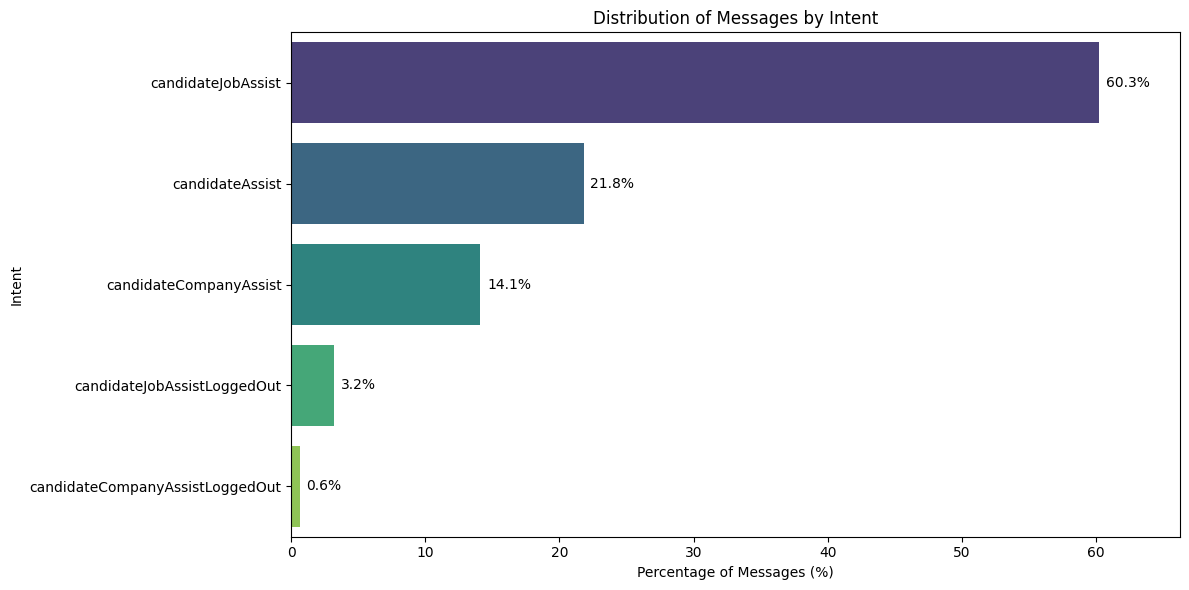


--- Analyzing Message Content ---
Checked 'content' column, filled missing values with empty strings.

Starting Word Frequency Analysis...
Using 208 stopwords (English default + custom).
Processing texts (tokenizing, cleaning, filtering)...
Found 0 words after processing and filtering.
No words were found after processing all messages. Skipping frequency analysis and plot.

Starting Sentiment Analysis using VADER...
Sentiment scores calculated and added to DataFrame as 'sentiment' column.


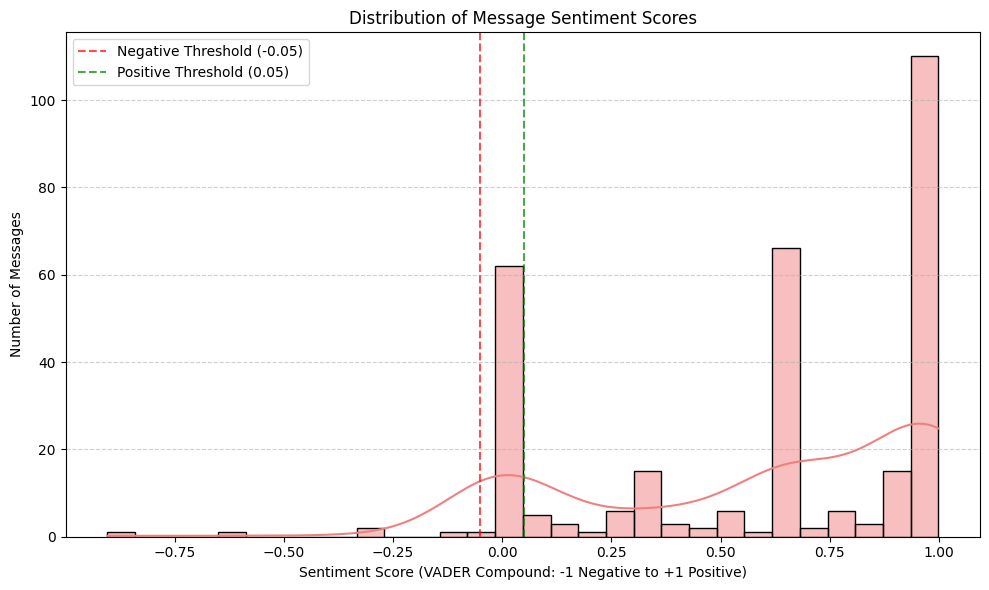


Overall Sentiment Distribution:
- Negative (< -0.05): 1.9%
- Neutral [-0.05 to 0.05]: 19.9%
- Positive (> 0.05): 78.2%

Sentiment Score Statistics:
count    312.000
mean       0.593
std        0.404
min       -0.904
25%        0.250
50%        0.660
75%        0.977
max        0.999
Name: sentiment, dtype: float64

--- Analysis Complete ---

 Script Finished 


In [14]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import sys

# --- Download required NLTK data ---
# Downloads 'punkt' for tokenization and 'stopwords' for filtering common words.
# quiet=True suppresses output if already downloaded.
print("Checking/Downloading required NLTK data...")
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("NLTK data is available.")
except Exception as e:
    print(f"Error downloading NLTK data: {e}")
    print("Please check your internet connection or NLTK setup.")
    # Depending on the importance, you might exit the script
    # sys.exit(1)

# --- Function Definitions ---

def load_json_file(filename):
    """Load a JSON file and return its contents."""
    try:
        print(f"Attempting to load JSON file: {filename}...")
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded {filename}")
        return data
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: The file '{filename}' is not valid JSON. Please check the file format.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading '{filename}': {e}")
        return None

def analyze_basic_stats(df):
    """Performs and plots basic analysis on message statistics (sender, intent)."""
    if df is None or df.empty:
        print("DataFrame is empty or None. Skipping basic stats analysis.")
        return df

    print("\n--- Analyzing Basic Message Statistics ---")
    print(f"Total messages found: {len(df)}")

    # Sender analysis (if 'sender' column exists)
    if 'sender' in df.columns:
        print("\nDistribution of messages by sender:")
        # Calculate value counts and percentages
        sender_counts = df['sender'].value_counts()
        sender_pcts = df['sender'].value_counts(normalize=True) * 100
        # Combine counts and percentages into a readable format
        sender_summary = pd.DataFrame({'count': sender_counts, 'percentage': sender_pcts.round(1)})
        print(sender_summary)
        # Optional: Plot sender distribution if few senders
        # if len(sender_counts) < 15: # Example threshold
        #     plt.figure(figsize=(10, 5))
        #     sns.barplot(x=sender_counts.index, y=sender_counts.values)
        #     plt.title('Message Count by Sender')
        #     plt.ylabel('Number of Messages')
        #     plt.xlabel('Sender')
        #     plt.xticks(rotation=45, ha='right')
        #     plt.tight_layout()
        #     plt.show()
    else:
        print("\nWarning: 'sender' column not found in the data. Skipping sender analysis.")

    # Intent analysis (if 'intent' column exists)
    if 'intent' in df.columns:
        print("\nDistribution of messages by intent:")
        intent_counts = df['intent'].value_counts()
        intent_pcts = df['intent'].value_counts(normalize=True) * 100
        intent_summary = pd.DataFrame({'count': intent_counts, 'percentage': intent_pcts.round(1)})
        print(intent_summary)

        # Plot intent distribution
        plt.figure(figsize=(12, max(6, len(intent_counts) * 0.5))) # Adjust height based on number of intents
        sns.barplot(x=intent_pcts.values, y=intent_pcts.index, palette="viridis")
        plt.title('Distribution of Messages by Intent')
        plt.xlabel('Percentage of Messages (%)')
        plt.ylabel('Intent')
        # Add percentage labels to bars
        for i, v in enumerate(intent_pcts):
            plt.text(v + 0.5, i, f'{v:.1f}%', va='center') # Adjust positioning
        plt.xlim(0, max(intent_pcts.values) * 1.1) # Ensure space for labels
        plt.tight_layout()
        plt.show()
    else:
        print("\nWarning: 'intent' column not found in the data. Skipping intent analysis.")

    return df # Return the dataframe (though not modified here)

def analyze_content(df):
    """Performs word frequency and sentiment analysis on the 'content' column."""
    if df is None or df.empty:
        print("DataFrame is empty or None. Skipping content analysis.")
        return df

    if 'content' not in df.columns:
        print("Warning: 'content' column not found. Skipping content analysis.")
        return df

    print("\n--- Analyzing Message Content ---")

    # Ensure 'content' column is string type and handle potential missing values
    df['content'] = df['content'].fillna('').astype(str)
    print("Checked 'content' column, filled missing values with empty strings.")

    # --- Word Frequency Analysis ---
    try:
        print("\nStarting Word Frequency Analysis...")
        # Define stopwords (common words to ignore)
        stop_words = set(stopwords.words('english'))
        # Add custom stopwords if needed (e.g., context-specific frequent but irrelevant words)
        custom_stopwords = {'', ' ', 'like', 'im', 'know', 'get', 'dont', 'also', 'us', 'one'} # Example custom words
        stop_words.update(custom_stopwords)
        print(f"Using {len(stop_words)} stopwords (English default + custom).")

        # Define text processing function
        def process_text(text):
            """Cleans, tokenizes, and filters text."""
            try:
                # 1. Lowercase
                text = text.lower()
                # 2. Keep only alphanumeric and spaces (remove punctuation/symbols)
                # Allows multi-word tokens initially if needed, split later
                text_cleaned = ''.join(char for char in text if char.isalnum() or char.isspace())
                # 3. Tokenize (split into words)
                tokens = word_tokenize(text_cleaned)
                # 4. Filter tokens
                filtered_tokens = [
                    word for word in tokens
                    if word.isalnum()           # Ensure it's purely alphanumeric after tokenization
                       and word not in stop_words # Check against stopwords
                       and len(word) > 2          # Keep words longer than 2 chars
                       and not word.isnumeric()   # Remove tokens that are just numbers
                ]
                return filtered_tokens
            except Exception as e:
                # Log error for a specific text chunk if needed
                # print(f"Error processing text chunk: '{text[:50]}...': {e}")
                return [] # Return empty list on error for this text chunk

        # Process all messages in the 'content' column
        print("Processing texts (tokenizing, cleaning, filtering)...")
        # Use apply for potentially better performance on large datasets
        processed_tokens_list = df['content'].apply(process_text)

        # Combine all processed words into a single list
        all_words = [word for sublist in processed_tokens_list for word in sublist]
        print(f"Found {len(all_words)} words after processing and filtering.")

        if not all_words:
            print("No words were found after processing all messages. Skipping frequency analysis and plot.")
        else:
            # Calculate word frequencies
            fdist = FreqDist(all_words)
            total_processed_words = sum(fdist.values()) # Total count of words *after* filtering
            print(f"Total unique words found: {len(fdist)}")

            if total_processed_words == 0:
                print("Word frequency distribution is empty. Skipping frequency plot.")
            else:
                # Plotting Top N Words
                top_words_count = 20
                common_words = fdist.most_common(top_words_count)

                if not common_words:
                    print("No common words found to plot.")
                else:
                    # Create DataFrame for plotting
                    top_words_df = pd.DataFrame(common_words, columns=['word', 'count'])
                    # Calculate percentage based on total *processed* words
                    top_words_df['percentage'] = (top_words_df['count'] / total_processed_words) * 100

                    # Plot
                    plt.figure(figsize=(12, 8))
                    # Sort by percentage for horizontal bar plot (ascending sort for descending plot)
                    top_words_df = top_words_df.sort_values('percentage', ascending=True)
                    bars = plt.barh(top_words_df['word'], top_words_df['percentage'], color='skyblue')

                    # Customize plot
                    plt.title(f'Top {top_words_count} Most Frequent Words (% of Total Processed Words)')
                    plt.xlabel('Percentage (%)')
                    plt.ylabel('Words')

                    # Add percentage labels on bars
                    for bar in bars:
                        width = bar.get_width()
                        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2., # Adjust text position
                                f'{width:.1f}%', ha='left', va='center')

                    plt.xlim(0, top_words_df['percentage'].max() * 1.15) # Adjust x-limit for labels
                    plt.tight_layout()
                    plt.show()

                    # Print top 10 words stats
                    print("\nTop 10 most frequent words:")
                    for word, count in fdist.most_common(10):
                        percentage = (count / total_processed_words) * 100
                        print(f"- {word}: {count} times ({percentage:.1f}%)")

    except Exception as e:
        print(f"\nAn error occurred during Word Frequency Analysis: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback for debugging

    # --- Sentiment Analysis ---
    try:
        print("\nStarting Sentiment Analysis using VADER...")
        analyzer = SentimentIntensityAnalyzer() # Initialize VADER

        # Define function to get VADER compound score safely
        def get_sentiment_score(text):
            """Calculates VADER compound sentiment score. Returns 0.0 on error."""
            try:
                # VADER expects a string
                return analyzer.polarity_scores(str(text))['compound']
            except Exception as e:
                # Log error for specific text if needed
                # print(f"Error getting sentiment for text: '{text[:50]}...': {e}")
                return 0.0 # Return neutral score on error

        # Apply sentiment analysis to the 'content' column
        # Creates a new 'sentiment' column in the DataFrame
        df['sentiment'] = df['content'].apply(get_sentiment_score)
        print("Sentiment scores calculated and added to DataFrame as 'sentiment' column.")

        # Plot Sentiment Distribution
        plt.figure(figsize=(10, 6))
        # Use seaborn for potentially nicer histogram plot
        sns.histplot(df['sentiment'], bins=30, kde=True, color='lightcoral') # Bins can be adjusted
        plt.title('Distribution of Message Sentiment Scores')
        plt.xlabel('Sentiment Score (VADER Compound: -1 Negative to +1 Positive)')
        plt.ylabel('Number of Messages') # Changed from percentage for histplot

        # Add vertical lines for typical sentiment boundaries
        plt.axvline(x=-0.05, color='red', linestyle='--', alpha=0.7, label='Negative Threshold (-0.05)')
        plt.axvline(x=0.05, color='green', linestyle='--', alpha=0.7, label='Positive Threshold (0.05)')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Print overall sentiment statistics
        print("\nOverall Sentiment Distribution:")
        negative_pct = (df['sentiment'] < -0.05).mean() * 100
        neutral_pct = ((df['sentiment'] >= -0.05) & (df['sentiment'] <= 0.05)).mean() * 100
        positive_pct = (df['sentiment'] > 0.05).mean() * 100

        print(f"- Negative (< -0.05): {negative_pct:.1f}%")
        print(f"- Neutral [-0.05 to 0.05]: {neutral_pct:.1f}%")
        print(f"- Positive (> 0.05): {positive_pct:.1f}%")

        # Print descriptive statistics of the sentiment scores
        print("\nSentiment Score Statistics:")
        print(df['sentiment'].describe().round(3))

    except Exception as e:
        print(f"\nAn error occurred during Sentiment Analysis: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback for debugging

    return df # Return the dataframe with the added 'sentiment' column

# --- Main Execution Block ---
# This code runs only when the script is executed directly (not imported as a module)
if __name__ == "__main__":
    print("=============================================")
    print(" Starting Message Analysis Script ")
    print("=============================================")

    # !!! IMPORTANT: Replace 'your_data_file.json' with the actual path to your JSON file !!!
    # Ensure the JSON file is in the same directory as the script, or provide the full path.
    json_filename = 'Parallel-Prod.AssistMessage.json' # <--- CHANGE THIS FILENAME

    # Step 1: Load the data
    raw_data = load_json_file(json_filename)

    # Proceed only if data loading was successful
    if raw_data is not None:
        # Step 2: Convert raw data to Pandas DataFrame
        try:
            # This assumes your JSON is structured as a list of objects/dictionaries.
            # Adjust if your structure is different.
            # e.g., if it's {'messages': [...]}, use pd.DataFrame(raw_data['messages'])
            df = pd.DataFrame(raw_data)
            print(f"\nData successfully converted to DataFrame.")
            print(f"DataFrame shape: {df.shape[0]} rows, {df.shape[1]} columns")
            print("Columns found:", df.columns.tolist())

            # Step 3: Perform analyses
            # Note: analyze_content modifies df by adding a 'sentiment' column
            df = analyze_basic_stats(df) # Perform basic stats analysis first
            df = analyze_content(df)     # Then perform content analysis

            print("\n--- Analysis Complete ---")

            # Optional: Save the DataFrame with sentiment scores to a new file
            # output_filename = 'analyzed_data.csv'
            # try:
            #    df.to_csv(output_filename, index=False, encoding='utf-8')
            #    print(f"\nDataFrame with sentiment scores saved successfully to {output_filename}")
            # except Exception as e:
            #    print(f"\nError saving DataFrame to CSV '{output_filename}': {e}")

        # Handle errors during DataFrame creation or analysis phases
        except ValueError as ve:
            print(f"\nError creating DataFrame: {ve}.")
            print("Check if the JSON structure is a list of records (dictionaries) suitable for DataFrame conversion.")
        except KeyError as ke:
            print(f"\nError accessing key during analysis: {ke}. Ensure required columns (e.g., 'content') exist.")
        except Exception as e:
            print(f"\nAn unexpected error occurred during DataFrame conversion or analysis: {e}")
            import traceback
            traceback.print_exc() # Print detailed traceback

    else:
        # Data loading failed
        print("\nExiting script because the JSON data could not be loaded.")

    print("\n=============================================")
    print(" Script Finished ")
    print("=============================================")



Checking/Downloading required NLTK data...
NLTK data is available.
 Starting Chat Message Analysis Script 
Attempting to load JSON file: Parallel-Prod.AssistMessage.json...
Successfully loaded 312 records from Parallel-Prod.AssistMessage.json

Data successfully converted to DataFrame.
DataFrame shape: 312 rows, 12 columns
Columns found: ['_id', 'content', 'sender', 'intent', 'assistThreadId', 'candidateId', 'botMessageId', 'botThreadId', 'createdAt', 'citations', 'companyId', 'jobId']

--- Analyzing Basic Message Statistics ---
Total messages loaded: 312

Distribution of messages by sender:
           count  percentage
sender                      
candidate    156        50.0
bot          156        50.0

Distribution of messages by intent:
                                 count  percentage
intent                                            
candidateJobAssist                 188        60.3
candidateAssist                     68        21.8
candidateCompanyAssist              44       

C:\Users\MR.Laptops\AppData\Local\Temp\ipykernel_31620\4209624513.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intent_pcts.values, y=intent_pcts.index, palette="viridis")


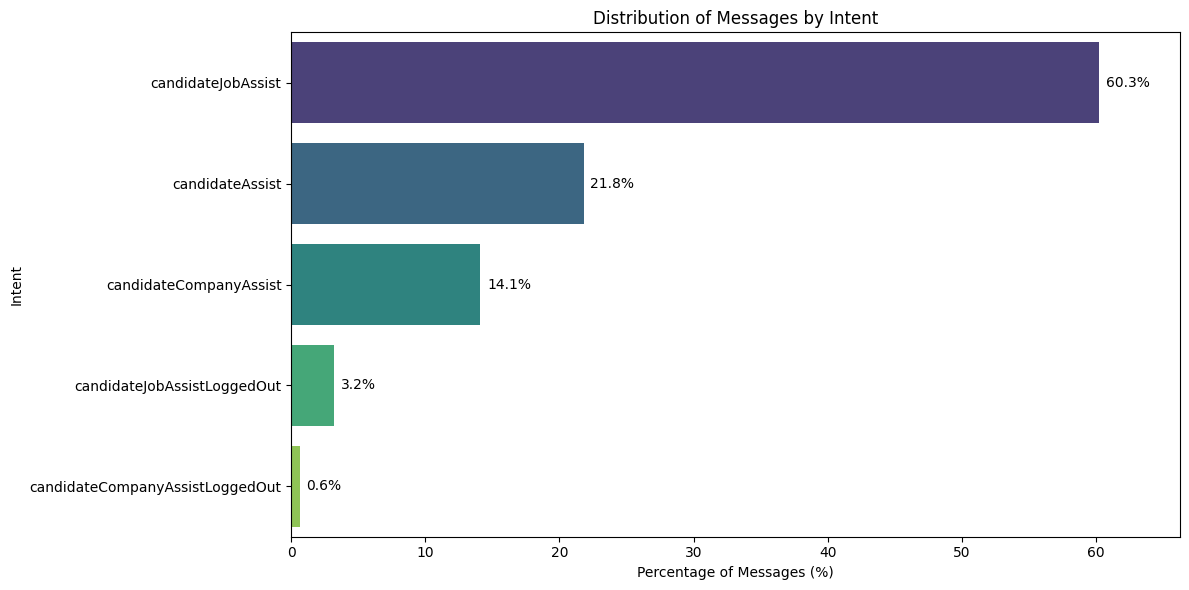


Analyzing message timestamps...


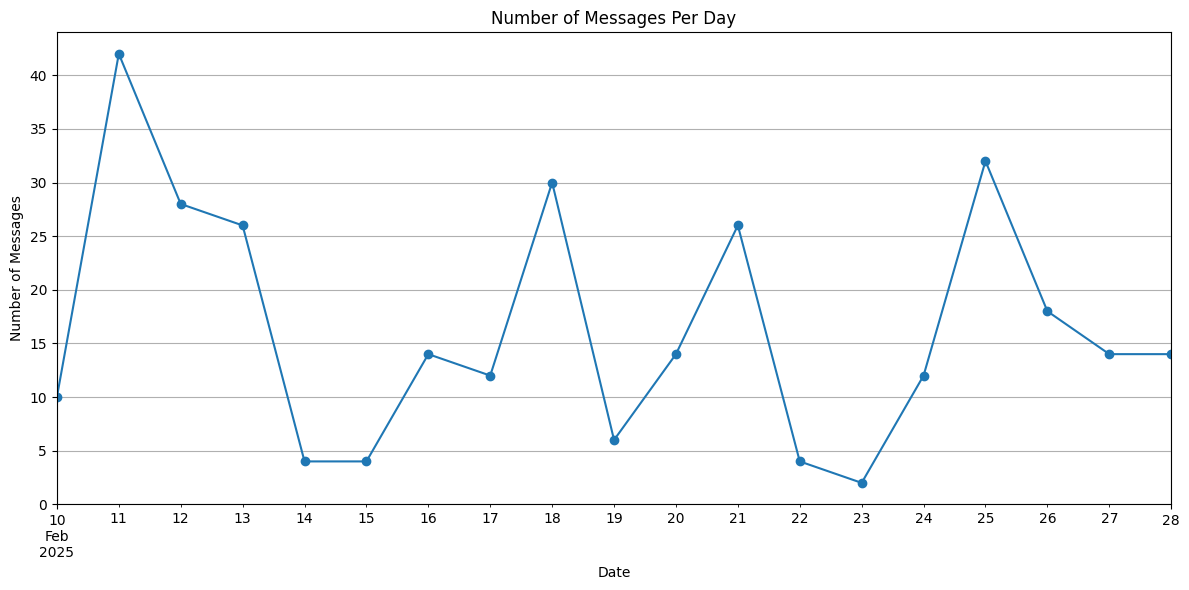


--- Analyzing Message Content ---
Checked 'content' column, filled potential missing values.

Starting Word Frequency Analysis...
Using 229 stopwords (English default + custom).
Processing texts (tokenizing, cleaning, filtering)...
Found 0 words after processing and filtering.
No words were found after processing all messages. Skipping frequency analysis and plot.

Starting Sentiment Analysis using VADER...
Sentiment scores calculated and added as 'sentiment' column.


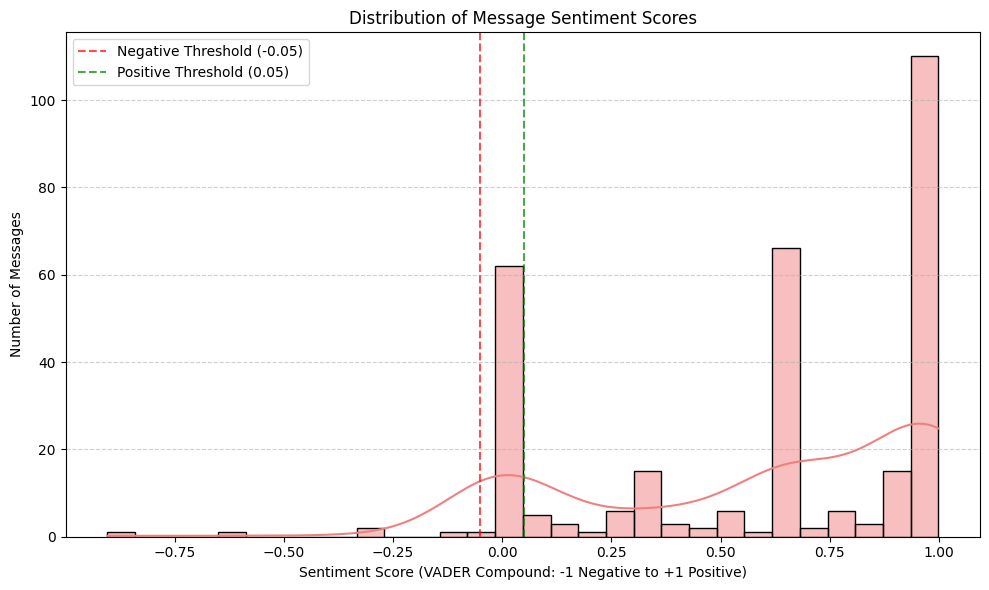


Overall Sentiment Distribution:
- Negative (< -0.05): 1.9%
- Neutral [-0.05 to 0.05]: 19.9%
- Positive (> 0.05): 78.2%

Sentiment Score Statistics:
count    312.000
mean       0.593
std        0.404
min       -0.904
25%        0.250
50%        0.660
75%        0.977
max        0.999
Name: sentiment, dtype: float64

--- Analysis Complete ---

 Script Finished 


In [16]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import sys
import re # Import regular expression module for potential advanced cleaning

# --- Download required NLTK data ---
# Downloads 'punkt' for tokenization and 'stopwords' for filtering common words.
# quiet=True suppresses output if already downloaded.
print("Checking/Downloading required NLTK data...")
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("NLTK data is available.")
except Exception as e:
    print(f"Error downloading NLTK data: {e}")
    print("Please check your internet connection or NLTK setup.")
    # sys.exit(1) # Optional: Exit if NLTK data is critical

# --- Function Definitions ---

def load_json_file(filename):
    """Load a JSON file containing a list of objects."""
    try:
        print(f"Attempting to load JSON file: {filename}...")
        with open(filename, 'r', encoding='utf-8') as f:
            # Use json.load for standard JSON array file [{}, {}]
            data = json.load(f)
        print(f"Successfully loaded {len(data)} records from {filename}")
        return data
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
        return None
    except json.JSONDecodeError as jde:
        print(f"Error: The file '{filename}' is not valid JSON. Please check the format.")
        print(f"Details: {jde}")
        # Attempt to load as JSON Lines (objects separated by newlines) as a fallback
        try:
            print(f"Attempting to load {filename} as JSON Lines format...")
            data = []
            with open(filename, 'r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip()
                    if line: # Avoid empty lines
                        data.append(json.loads(line))
            print(f"Successfully loaded {len(data)} records from {filename} using JSON Lines format.")
            return data
        except Exception as e:
             print(f"Failed to load as JSON Lines format as well. Error: {e}")
             return None
    except Exception as e:
        print(f"An unexpected error occurred while loading '{filename}': {e}")
        return None

def analyze_basic_stats(df):
    """Performs and plots basic analysis on message statistics (sender, intent)."""
    if df is None or df.empty:
        print("DataFrame is empty or None. Skipping basic stats analysis.")
        return df

    print("\n--- Analyzing Basic Message Statistics ---")
    print(f"Total messages loaded: {len(df)}")

    # Sender analysis
    if 'sender' in df.columns:
        print("\nDistribution of messages by sender:")
        sender_counts = df['sender'].value_counts()
        sender_pcts = df['sender'].value_counts(normalize=True) * 100
        sender_summary = pd.DataFrame({'count': sender_counts, 'percentage': sender_pcts.round(1)})
        print(sender_summary)
    else:
        print("\nWarning: 'sender' column not found. Skipping sender analysis.")

    # Intent analysis
    if 'intent' in df.columns:
        print("\nDistribution of messages by intent:")
        intent_counts = df['intent'].value_counts()
        intent_pcts = df['intent'].value_counts(normalize=True) * 100
        intent_summary = pd.DataFrame({'count': intent_counts, 'percentage': intent_pcts.round(1)})
        print(intent_summary)

        # Plot intent distribution if there are intents to plot
        if not intent_pcts.empty:
            plt.figure(figsize=(12, max(6, len(intent_counts) * 0.5)))
            sns.barplot(x=intent_pcts.values, y=intent_pcts.index, palette="viridis")
            plt.title('Distribution of Messages by Intent')
            plt.xlabel('Percentage of Messages (%)')
            plt.ylabel('Intent')
            for i, v in enumerate(intent_pcts):
                plt.text(v + 0.5, i, f'{v:.1f}%', va='center')
            plt.xlim(0, max(intent_pcts.values) * 1.1 if intent_pcts.values.size > 0 else 10) # Adjust x-limit
            plt.tight_layout()
            plt.show()
        else:
            print("No intent data found to plot.")
    else:
        print("\nWarning: 'intent' column not found. Skipping intent analysis.")

    # Optional: Analyze Date/Time if 'createdAt' exists and is parsed correctly
    if 'createdAt' in df.columns:
        try:
            # Attempt to convert the nested date structure to datetime
            # Handle both string dates and the {"$date": ...} structure
            def extract_date(x):
                if isinstance(x, dict) and '$date' in x:
                    return x['$date']
                return x # Assume it might already be a parsable string

            df['timestamp'] = pd.to_datetime(df['createdAt'].apply(extract_date), errors='coerce')
            # Drop rows where conversion failed
            df.dropna(subset=['timestamp'], inplace=True)

            if not df['timestamp'].empty:
                print("\nAnalyzing message timestamps...")
                # Example: Plot messages over time (e.g., per day)
                plt.figure(figsize=(12, 6))
                df['timestamp'].dt.floor('D').value_counts().sort_index().plot(kind='line', marker='o')
                plt.title('Number of Messages Per Day')
                plt.xlabel('Date')
                plt.ylabel('Number of Messages')
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print("Could not extract valid timestamps from 'createdAt' column.")

        except Exception as e:
            print(f"\nWarning: Could not process 'createdAt' column for time analysis. Error: {e}")


    return df # Return the dataframe

def analyze_content(df):
    """Performs word frequency and sentiment analysis on the 'content' column."""
    if df is None or df.empty:
        print("DataFrame is empty or None. Skipping content analysis.")
        return df

    if 'content' not in df.columns:
        print("Warning: 'content' column not found. Skipping content analysis.")
        return df

    print("\n--- Analyzing Message Content ---")

    # Ensure 'content' is string, fill missing values
    df['content'] = df['content'].fillna('').astype(str)
    print("Checked 'content' column, filled potential missing values.")

    # --- Word Frequency Analysis ---
    try:
        print("\nStarting Word Frequency Analysis...")
        # Define stopwords
        stop_words = set(stopwords.words('english'))
        # More comprehensive custom stopwords - add domain-specific words if needed
        custom_stopwords = {
            '', ' ', 'also', 'would', 'could', 'should', 'might', 'may', 'like', 'im',
            'know', 'get', 'dont', 'cant', 'well', 'us', 'one', 'see', 'use', 'need',
            'want', 'make', 'go', 'com', # Often from URLs if not cleaned
            # Consider adding words specific to your chat context if they are noise
            'salary', 'range', 'market', 'expectations', # From your example, if too frequent
            'engineer', 'software', 'los', 'angeles' # From your example
            }
        stop_words.update(custom_stopwords)
        print(f"Using {len(stop_words)} stopwords (English default + custom).")

        # Define text processing function
        def process_text(text):
            """Cleans, tokenizes, and filters text."""
            try:
                # 1. Lowercase
                text = text.lower()
                # 2. Remove URLs (optional but recommended)
                text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
                # 3. Remove email addresses (optional)
                text = re.sub(r'\S+@\S+', '', text)
                # 4. Remove numbers / amounts with symbols (e.g., $146,079) - keep words
                text = re.sub(r'[\$\d,\.]+', '', text) # Removes monetary values, numbers with commas/dots
                # 5. Remove punctuation and non-alphanumeric (keep spaces)
                text_cleaned = ''.join(char for char in text if char.isalnum() or char.isspace())
                # 6. Tokenize
                tokens = word_tokenize(text_cleaned)
                # 7. Filter tokens
                filtered_tokens = [
                    word for word in tokens
                    if word.isalnum()           # Ensure purely alphanumeric
                       and word not in stop_words # Check against stopwords
                       and len(word) > 2          # Keep words longer than 2 chars
                       # 'isnumeric' check is less needed after step 4, but keep as safeguard
                       and not word.isnumeric()
                ]
                return filtered_tokens
            except Exception as e:
                # print(f"Error processing text chunk: '{text[:50]}...': {e}")
                return []

        # --- Debugging Print Statements (Uncomment ONE line inside process_text if needed) ---
        # print(f"Original: '{text[:100]}'")
        # print(f"Cleaned: '{text_cleaned[:100]}'")
        # print(f"Tokens: {tokens[:20]}")
        # print(f"Filtered Tokens: {filtered_tokens[:20]}")
        # print("-" * 20)
        # --- End Debugging ---


        # Process all messages
        print("Processing texts (tokenizing, cleaning, filtering)...")
        processed_tokens_list = df['content'].apply(process_text)
        all_words = [word for sublist in processed_tokens_list for word in sublist]
        print(f"Found {len(all_words)} words after processing and filtering.") # THIS IS THE KEY OUTPUT TO CHECK

        if not all_words:
            print("No words were found after processing all messages. Skipping frequency analysis and plot.")
        else:
            # Calculate word frequencies
            fdist = FreqDist(all_words)
            total_processed_words = sum(fdist.values())
            print(f"Total unique words found: {len(fdist)}")

            if total_processed_words == 0:
                print("Word frequency distribution is empty. Skipping frequency plot.")
            else:
                # Plotting Top N Words
                top_words_count = 20
                common_words = fdist.most_common(top_words_count)

                if not common_words:
                    print("No common words found to plot.")
                else:
                    top_words_df = pd.DataFrame(common_words, columns=['word', 'count'])
                    top_words_df['percentage'] = (top_words_df['count'] / total_processed_words) * 100

                    plt.figure(figsize=(12, 8))
                    top_words_df = top_words_df.sort_values('percentage', ascending=True)
                    bars = plt.barh(top_words_df['word'], top_words_df['percentage'], color='skyblue')

                    plt.title(f'Top {top_words_count} Most Frequent Words (% of Total Processed Words)')
                    plt.xlabel('Percentage (%)')
                    plt.ylabel('Words')
                    for bar in bars:
                        width = bar.get_width()
                        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2.,
                                f'{width:.1f}%', ha='left', va='center')
                    plt.xlim(0, top_words_df['percentage'].max() * 1.15)
                    plt.tight_layout()
                    plt.show()

                    print("\nTop 10 most frequent words:")
                    for word, count in fdist.most_common(10):
                        percentage = (count / total_processed_words) * 100
                        print(f"- {word}: {count} times ({percentage:.1f}%)")

    except Exception as e:
        print(f"\nAn error occurred during Word Frequency Analysis: {e}")
        import traceback
        traceback.print_exc()

    # --- Sentiment Analysis ---
    try:
        print("\nStarting Sentiment Analysis using VADER...")
        analyzer = SentimentIntensityAnalyzer()

        def get_sentiment_score(text):
            """Calculates VADER compound sentiment score. Returns 0.0 on error."""
            try:
                return analyzer.polarity_scores(str(text))['compound']
            except Exception as e:
                # print(f"Error getting sentiment for text: '{text[:50]}...': {e}")
                return 0.0

        # Apply sentiment analysis
        df['sentiment'] = df['content'].apply(get_sentiment_score)
        print("Sentiment scores calculated and added as 'sentiment' column.")

        # Plot Sentiment Distribution
        if not df['sentiment'].empty:
            plt.figure(figsize=(10, 6))
            sns.histplot(df['sentiment'], bins=30, kde=True, color='lightcoral')
            plt.title('Distribution of Message Sentiment Scores')
            plt.xlabel('Sentiment Score (VADER Compound: -1 Negative to +1 Positive)')
            plt.ylabel('Number of Messages')
            plt.axvline(x=-0.05, color='red', linestyle='--', alpha=0.7, label='Negative Threshold (-0.05)')
            plt.axvline(x=0.05, color='green', linestyle='--', alpha=0.7, label='Positive Threshold (0.05)')
            plt.legend()
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

            # Print overall sentiment statistics
            print("\nOverall Sentiment Distribution:")
            negative_pct = (df['sentiment'] < -0.05).mean() * 100
            neutral_pct = ((df['sentiment'] >= -0.05) & (df['sentiment'] <= 0.05)).mean() * 100
            positive_pct = (df['sentiment'] > 0.05).mean() * 100
            print(f"- Negative (< -0.05): {negative_pct:.1f}%")
            print(f"- Neutral [-0.05 to 0.05]: {neutral_pct:.1f}%")
            print(f"- Positive (> 0.05): {positive_pct:.1f}%")

            print("\nSentiment Score Statistics:")
            print(df['sentiment'].describe().round(3))
        else:
            print("No sentiment scores generated to plot or analyze.")

    except Exception as e:
        print(f"\nAn error occurred during Sentiment Analysis: {e}")
        import traceback
        traceback.print_exc()

    return df # Return the dataframe with 'sentiment' column (and potentially 'timestamp')

# --- Main Execution Block ---
if __name__ == "__main__":
    print("=============================================")
    print(" Starting Chat Message Analysis Script ")
    print("=============================================")

    # !!! --- IMPORTANT: SET YOUR JSON FILENAME HERE --- !!!
    json_filename = 'Parallel-Prod.AssistMessage.json'  # <--- CHANGE THIS TO YOUR ACTUAL FILENAME
    # !!! -------------------------------------------- !!!

    # Step 1: Load the data
    raw_data = load_json_file(json_filename)

    # Proceed only if data loading was successful
    if raw_data is not None and isinstance(raw_data, list) and len(raw_data) > 0:
        # Step 2: Convert raw data to Pandas DataFrame
        try:
            # pd.DataFrame handles list of dicts directly.
            # Nested dicts (like _id, createdAt) become object columns.
            df = pd.DataFrame(raw_data)
            print(f"\nData successfully converted to DataFrame.")
            print(f"DataFrame shape: {df.shape[0]} rows, {df.shape[1]} columns")
            print("Columns found:", df.columns.tolist())
            # print("\nDataFrame head:\n", df.head()) # Uncomment to see first few rows

            # Optional: Flatten nested structures if needed for specific analysis
            # Example: Flatten '_id' into 'id'
            # try:
            #     df['id'] = df['_id'].apply(lambda x: x['$oid'] if isinstance(x, dict) and '$oid' in x else None)
            #     # df = df.drop(columns=['_id']) # Optionally drop original nested column
            #     print("Extracted '_id.$oid' into 'id' column.")
            # except Exception as e:
            #     print(f"Could not flatten '_id' column: {e}")

            # Step 3: Perform analyses
            df = analyze_basic_stats(df) # Basic sender, intent, time analysis
            df = analyze_content(df)     # Word frequency and sentiment on 'content'

            print("\n--- Analysis Complete ---")

            # Optional: Save the analyzed DataFrame
            # output_filename = 'analyzed_chat_data.csv'
            # try:
            #    df.to_csv(output_filename, index=False, encoding='utf-8')
            #    print(f"\nAnalyzed DataFrame saved successfully to {output_filename}")
            # except Exception as e:
            #    print(f"\nError saving DataFrame to CSV '{output_filename}': {e}")

        # Handle errors during DataFrame creation or analysis phases
        except ValueError as ve:
            print(f"\nError creating DataFrame: {ve}.")
            print("Check if the JSON structure is a list of records (dictionaries).")
        except KeyError as ke:
            print(f"\nError accessing key during analysis: {ke}. Ensure required columns (e.g., 'content', 'sender', 'intent') exist or handle their absence.")
        except Exception as e:
            print(f"\nAn unexpected error occurred during DataFrame conversion or analysis: {e}")
            import traceback
            traceback.print_exc() # Print detailed traceback

    elif raw_data is None:
        print("\nExiting script because the JSON data could not be loaded.")
    else:
        print("\nLoaded data is not in the expected format (list of records). Exiting.")


    print("\n=============================================")
    print(" Script Finished ")
    print("=============================================")

